In [116]:
import sys
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.datasets import load_digits
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

tf.logging.set_verbosity(tf.logging.ERROR)

from getConfig     import getConfig
from getData       import getData
from buildGAN import buildGAN

In [2]:
plt.rcParams.update({'axes.titlesize': 'small'})

In [3]:
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
#Those attributes will be required for the final part of the assignment (applying smiles), so please keep them in mind
config = getConfig()
images, attributes = getData(config)

In [4]:
#print random image
#plt.imshow(images[np.random.randint(images.shape[0])], cmap="gray", interpolation="none")

In [5]:
gen = buildGAN(config, "generator")
disc = buildGAN(config, "discriminator")

In [6]:
imgShape=(config["dimX"], config["dimY"], 3)

noise = tf.placeholder('float32',[None,config["codeSize"]])     # Input to the generator
realData = tf.placeholder('float32',[None,]+list(imgShape))   # Input to the discriminator (actual images)

logp_real = disc(realData)
logp_gen = disc(gen(noise))

In [117]:
# Loss functions:
# column 0 is Real probability; column 1 is fake
discLoss = -tf.reduce_mean(logp_real[:,1] + logp_gen[:,0])
genLoss = -tf.reduce_mean(logp_gen[:,1])

#regularize
discLoss += tf.reduce_mean(disc.layers[-1].kernel**2)

#optimizers
discOptimizer =  tf.train.GradientDescentOptimizer(1e-3).minimize(discLoss,var_list=disc.trainable_weights)
genOptimizer = tf.train.AdamOptimizer(1e-4).minimize(genLoss,var_list=gen.trainable_weights)    

In [118]:
def getRealBatch(config):
    idxs = np.random.choice(np.arange(images.shape[0]), size=config["batchSize"])
    return images[idxs]
def getNoiseBatch(config):
    return np.random.normal(size=(config["batchSize"], config["codeSize"])).astype('float32')

In [128]:
def saveModels(config, gen, disc, epoch):
    loc = config["modelDir"]
    filename = "gen_" + str(epoch) + ".h5"
    gen.save(loc+filename)
    
    filename = "disc_" + str(epoch) + ".h5"
    disc.save(loc+filename)

In [132]:
start = time.time()
epochs = 4
discLoops = 5
genLoops = 3
print("{:<8}{:<12}".format("Epoch", "Loss"))

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for epoch in range(epochs):
        feedDict = {
            realData:getRealBatch(config),
            noise: getNoiseBatch(config)
        }
        
        # Train Discriminator
        for i in range(discLoops):
            sess.run(discOptimizer, feedDict)
            
        if epoch%100 == 0 and epoch > 0:
            loss = sess.run(discLoss, feedDict)
            print("{:<8}{:<8.2}".format(epoch, loss))
        
        # Train Generator
        for i in range(genLoops):
            sess.run(genOptimizer, feedDict)
            
        if epoch%1000 == 0 and epoch > 0:
            saveModels(config, gen, disc, epoch)
    
    saveModels(config, gen, disc, "Final")
    
    elapsed = (time.time()-start)/60
    print("Done after {:.0f} minutes ({:.0f} minutes per 100 epochs)".format(elapsed, elapsed/epochs*100 ))

Epoch   Loss        
Done after 1 minutes (22 minutes per 100 epochs)


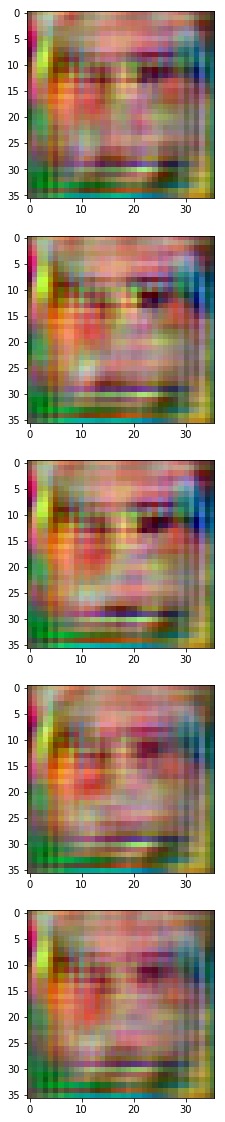

In [125]:
plt.figure(figsize=(20,20))
for i in range(5):
    plt.subplot(5,1,i+1)
    plt.imshow(after[i].clip(0,1))

In [154]:
count = 0
for _ in range(400):
    n = np.random.randint(100)/100
    if n > 0.4:
        count += 1

In [155]:
count

217